In [1]:
!/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade --ignore-installed --force-reinstall https://s3-us-west-2.amazonaws.com/move-dl-common-binary-distrubution/python/move_dl_common_api-3.2.131-release.tar.gz
!pip install pyarrow
!pip install dask
#Clean up previous tables
from move_dl_common_api.athena_util import AthenaUtil
from datetime import datetime
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from datetime import datetime
import pyarrow.parquet as pq
import dask.dataframe as dd
import s3fs
import multiprocessing
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot
s3 = s3fs.S3FileSystem()

  Using cached https://s3-us-west-2.amazonaws.com/move-dl-common-binary-distrubution/python/move_dl_common_api-3.2.131-release.tar.gz
  Using cached https://files.pythonhosted.org/packages/41/dc/68f39fcba61ae642579aca134e2b1139cea4e10341c96772e05c4b0fa727/boto3-1.9.217-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/86/79/b4a87f7b177a65dbe5029201fc9d3901e33c2b5f925452ba1cc1fbfff652/botocore-1.12.217-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/16/8a/1fc3dba0c4923c2a76e1ff0d52b305c44606da63f718d14d3231e21c51b0/s3transfer-0.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e6/60/247f23a7121ae632d62811ba7f273d0e58972d75e58a94d329d51550a47d/urllib3-1.25.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd

In [2]:
# I try to do join on CAP and LEAD for initial data set
# The join condition is based on snap_shot_time
s3_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions'
util = AthenaUtil(s3_staging_folder = s3_path)
# Time to take snap shot
time_stamp = "20190620"

# Drop table if exists
ctas_query_drop_cap_001_timestamp = """DROP TABLE buyer_intent_user_interactions.biui_qa_cap_summary_t001_{};""".format(time_stamp)
util.execute_query(sql_query = ctas_query_drop_cap_001_timestamp)

# Creat Table Again
ctas_query_cap_001_timestamp="""CREATE TABLE buyer_intent_user_interactions.biui_qa_cap_summary_t001_{}
WITH ( format='PARQUET' ) AS
SELECT *
FROM buyer_intent_user_interactions.biui_qa_consumer_analytical_profile_summary_t001
WHERE snapshot_date_mst_yyyymmdd = '{}';""".format(time_stamp,
                                                   time_stamp)

util.execute_query(sql_query = ctas_query_cap_001_timestamp)

2019-08-27 21:32:07.152 INFO athena_util.py.111 - Read config from default schema
2019-08-27 21:32:07.153 INFO athena_util.py.114 - Schema fetched from default config file:
2019-08-27 21:32:07.154 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:32:07.296 INFO athena_util.py.462 - 2019-08-27 21:32:07.296360
2019-08-27 21:32:09.937 INFO athena_util.py.464 - 2019-08-27 21:32:09.937745
2019-08-27 21:32:10.001 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:32:10.129 INFO athena_util.py.462 - 2019-08-27 21:32:10.129483
2019-08-27 21:32:16.837 INFO athena_util.py.464 - 2019-08-27 21:32:16.837816


{'UpdateCount': 27174,
 'ResultSet': {'Rows': [],
  'ResultSetMetadata': {'ColumnInfo': [{'CatalogName': 'hive',
     'SchemaName': '',
     'TableName': '',
     'Name': 'rows',
     'Label': 'rows',
     'Type': 'bigint',
     'Precision': 19,
     'Scale': 0,
     'Nullable': 'UNKNOWN',
     'CaseSensitive': False}]}},
 'ResponseMetadata': {'RequestId': 'c0fd6076-9783-4f1a-a9ed-ab46ddf67b1d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 27 Aug 2019 21:32:16 GMT',
   'x-amzn-requestid': 'c0fd6076-9783-4f1a-a9ed-ab46ddf67b1d',
   'content-length': None,
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [3]:
# Drop table if exists
ctas_query_drop_cap_lead_001_timestamp = """DROP TABLE buyer_intent_user_interactions.biui_qa_cap_lead_summary_t001_{};""".format(time_stamp)
util.execute_query(sql_query = ctas_query_drop_cap_lead_001_timestamp)

ctas_query_cap_lead_001_timestamp="""CREATE TABLE buyer_intent_user_interactions.biui_qa_cap_lead_summary_t001_{}
WITH ( format='PARQUET' ) AS
SELECT *
FROM buyer_intent_user_interactions.biui_qa_consumer_analytical_profile_leads_t001
WHERE snapshot_date_mst_yyyymmdd = '{}';""".format(time_stamp,time_stamp)

util.execute_query(sql_query = ctas_query_cap_lead_001_timestamp)

2019-08-27 21:32:16.919 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:32:16.984 INFO athena_util.py.462 - 2019-08-27 21:32:16.984557
2019-08-27 21:32:18.530 INFO athena_util.py.464 - 2019-08-27 21:32:18.530872
2019-08-27 21:32:18.623 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:32:18.676 INFO athena_util.py.462 - 2019-08-27 21:32:18.676591
2019-08-27 21:32:23.832 INFO athena_util.py.464 - 2019-08-27 21:32:23.832270


{'UpdateCount': 808,
 'ResultSet': {'Rows': [],
  'ResultSetMetadata': {'ColumnInfo': [{'CatalogName': 'hive',
     'SchemaName': '',
     'TableName': '',
     'Name': 'rows',
     'Label': 'rows',
     'Type': 'bigint',
     'Precision': 19,
     'Scale': 0,
     'Nullable': 'UNKNOWN',
     'CaseSensitive': False}]}},
 'ResponseMetadata': {'RequestId': 'a5f1ac2c-bf2a-4efd-8ae8-5401620855db',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 27 Aug 2019 21:32:23 GMT',
   'x-amzn-requestid': 'a5f1ac2c-bf2a-4efd-8ae8-5401620855db',
   'content-length': None,
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [4]:
s3_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions_stage'
util = AthenaUtil(s3_staging_folder = s3_path)

2019-08-27 21:32:23.896 INFO athena_util.py.111 - Read config from default schema
2019-08-27 21:32:23.896 INFO athena_util.py.114 - Schema fetched from default config file:


In [5]:
param_dict = {
    's3_path': 's3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables',
     #this time could be changed
    'snap_shot_date':time_stamp,
    'cap_summary_time_filtered':'biui_qa_cap_summary_t001',
    'caplead_summary_time_filtered':'biui_qa_cap_lead_summary_t001'
}

In [6]:
!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables
ctas_drop_cap_lead_trans_001 = """DROP TABLE buyer_intent_user_interactions_stage.cap_lead_trans_001_{};""".format(time_stamp)
util.execute_query(sql_query = ctas_drop_cap_lead_trans_001)

ctas_create_cap_lead_trans_001 = """CREATE TABLE buyer_intent_user_interactions_stage.cap_lead_trans_001_{snap_shot_date} WITH (
external_location = '{s3_path}/cap_lead_trans_001_{snap_shot_date}',
format='PARQUET'
) AS
SELECT
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.member_id,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_saved_listings,
-- Search behaviour of the user
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_saved_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_srp_dwell_time_seconds,
-- Exploring different items with more detail interactions
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_ldp_page_views,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_page_views,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_page_views,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_distinct_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_distinct_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_distinct_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_number_of_bath_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_number_of_bed_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_current_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_number_of_bath_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_number_of_bed_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_current_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_number_of_bath_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_number_of_bed_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_current_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_original_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_original_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_original_price,
-- Behavior of the user in submitting leads
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_leads_submitted,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.submitted_leads_for_rent,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.submitted_leads_for_sale,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.submitted_leads_not_for_sale,
-- Behaviour for doing transactions
buyer_intent_user_interactions.{caplead_summary_time_filtered}_{snap_shot_date}.consumer_score_probablity_to_transact
FROM buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date} INNER JOIN buyer_intent_user_interactions.{caplead_summary_time_filtered}_{snap_shot_date}
ON buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.member_id = buyer_intent_user_interactions.{caplead_summary_time_filtered}_{snap_shot_date}.member_id
WHERE buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.ldp_dominant_segment = 'for sale';""".format(**param_dict)
util.execute_query(sql_query = ctas_create_cap_lead_trans_001)

delete: s3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables/bf2bb4b7-a476-42c4-94b5-5f8066e990aa.metadata
delete: s3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables/cap_lead_trans_030_20190620/20190826_233227_00019_mt6tm_1cb83c6a-ad34-486d-8626-8202c9d9c9fc
delete: s3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables/cap_lead_trans_030_20190620/20190826_233227_00019_mt6tm_2bef50b5-20cd-4682-ba11-8bf0cdda6ced
delete: s3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables/cap_lead_trans_030_20190620/20190826_233227_00019_mt6tm_c8dc1ff1-f058-4eb4-a33d-dd28b6e2f8b7
delete: s3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables/cap_lead_trans_030_20190620/20190826_233227_00019_mt6tm_81965ecc-b770-40e9-be8e-26cb9cbb31b6
2019-08-27 21:32:24.766 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions_stage
2019-08-27 21:32:24.824 INFO athena_util.py.462 -

{'UpdateCount': 80,
 'ResultSet': {'Rows': [],
  'ResultSetMetadata': {'ColumnInfo': [{'CatalogName': 'hive',
     'SchemaName': '',
     'TableName': '',
     'Name': 'rows',
     'Label': 'rows',
     'Type': 'bigint',
     'Precision': 19,
     'Scale': 0,
     'Nullable': 'UNKNOWN',
     'CaseSensitive': False}]}},
 'ResponseMetadata': {'RequestId': '72b19c6b-78cf-439b-bf14-b972d17b189b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 27 Aug 2019 21:32:29 GMT',
   'x-amzn-requestid': '72b19c6b-78cf-439b-bf14-b972d17b189b',
   'content-length': None,
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [7]:
s3_data_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables/cap_lead_trans_001_{snap_shot_date}'.format(**param_dict)

In [8]:
df_for_sale_001 = pq.ParquetDataset(s3_data_path, filesystem=s3).read_pandas().to_pandas()
df_for_sale_001.head(5)

,member_id,total_saved_listings,total_searches,total_saved_searches,median_searches,average_searches,median_search_min_price,average_search_min_price,minimum_search_min_price,maximum_search_min_price,...,standard_deviation_ldp_listing_number_of_bed_rooms,standard_deviation_ldp_listing_current_price,median_ldp_listing_original_price,average_ldp_listing_original_price,standard_deviation_ldp_listing_original_price,total_leads_submitted,submitted_leads_for_rent,submitted_leads_for_sale,submitted_leads_not_for_sale,consumer_score_probablity_to_transact
0,5bf00baa973cc46095009f58,0,3,0,3,3.0,NaN,NaN,NaN,NaN,...,0.000000,0.000000,435000.0,435000.000000,0.000000,1,1,1,1,NaN
1,57b859916c3ed759d6001ab1,1,23,0,23,23.0,350000.0,350000.0,350000.0,350000.0,...,0.444262,37082.169438,435000.0,421246.750000,37082.169438,1,1,1,1,NaN
2,5a6cf58e99303ab57a1bf539,0,4,0,4,4.0,NaN,NaN,NaN,NaN,...,NaN,35118.845843,49900.0,53233.333333,35118.845843,2,2,2,2,0.60
3,5a6cf58e99303ab57a1bf539,0,4,0,4,4.0,NaN,NaN,NaN,NaN,...,NaN,35118.845843,49900.0,53233.333333,35118.845843,2,2,2,2,0.33
4,5ac4065f81f95f9de44a5864,0,6,0,6,6.0,NaN,NaN,NaN,NaN,...,0.707107,103624.515814,99900.0,130844.444444,103624.515814,1,1,1,1,0.61


In [9]:
#Clean up columns and rows if all elements are empty
df_for_sale_001 = df_for_sale_001.dropna(axis = 0, how='all')
df_for_sale_001 = df_for_sale_001.dropna(axis = 1, how='all')

In [10]:
#Clean all colomns with the same value
nunique = df_for_sale_001.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df_for_sale_001 = df_for_sale_001.drop(cols_to_drop, axis=1)

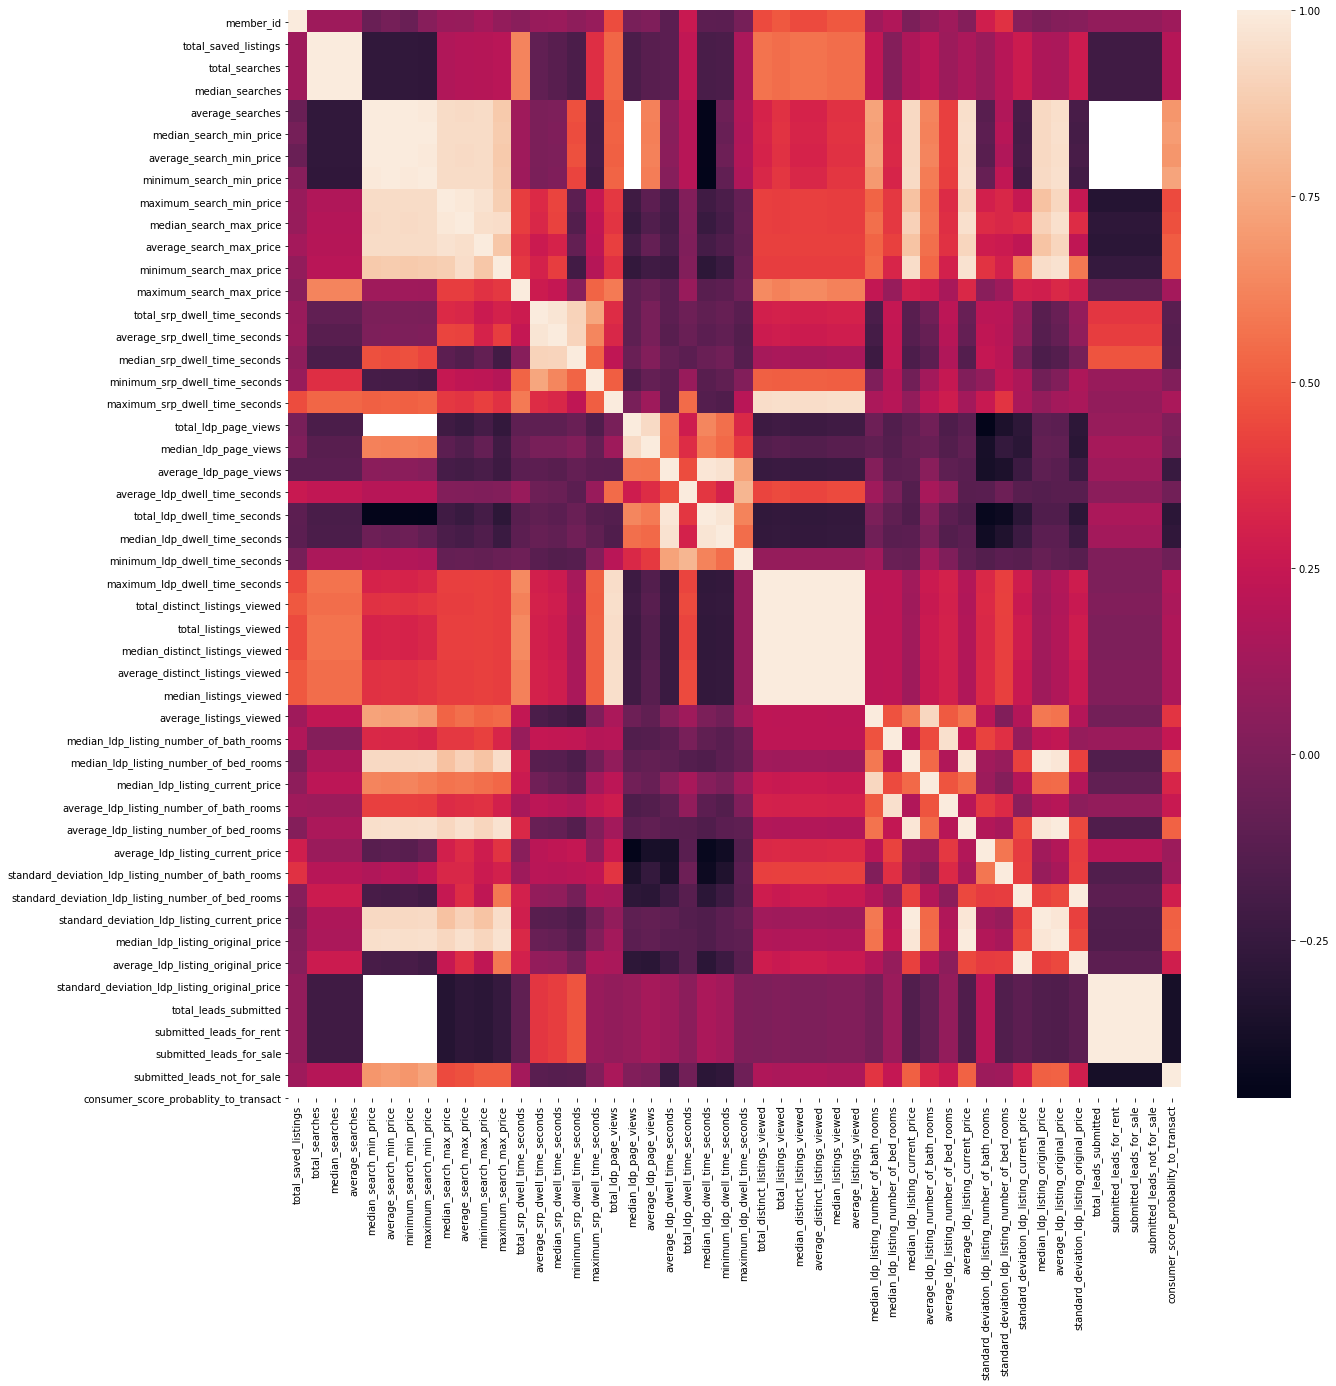

In [11]:
df_for_sale_001_corr = df_for_sale_001.corr()
pyplot.figure(figsize=(20, 20))
sns.heatmap(df_for_sale_001_corr, xticklabels=df_for_sale_001_corr.columns, yticklabels=df_for_sale_001.columns)

In [12]:
df_for_sale_001 = df_for_sale_001.drop(columns = ['total_distinct_listings_viewed','total_listings_viewed','median_distinct_listings_viewed','average_distinct_listings_viewed', 
                                          'median_listings_viewed','average_listings_viewed','submitted_leads_for_rent','submitted_leads_for_sale', 'submitted_leads_not_for_sale'])
df_for_sale_001.head(5)

,member_id,total_saved_listings,total_searches,median_searches,average_searches,median_search_min_price,average_search_min_price,minimum_search_min_price,maximum_search_min_price,median_search_max_price,...,average_ldp_listing_number_of_bed_rooms,average_ldp_listing_current_price,standard_deviation_ldp_listing_number_of_bath_rooms,standard_deviation_ldp_listing_number_of_bed_rooms,standard_deviation_ldp_listing_current_price,median_ldp_listing_original_price,average_ldp_listing_original_price,standard_deviation_ldp_listing_original_price,total_leads_submitted,consumer_score_probablity_to_transact
0,5bf00baa973cc46095009f58,0,3,3,3.0,NaN,NaN,NaN,NaN,NaN,...,3.000000,435000.000000,0.000000,0.000000,0.000000,435000.0,435000.000000,0.000000,1,NaN
1,57b859916c3ed759d6001ab1,1,23,23,23.0,350000.0,350000.0,350000.0,350000.0,500000.0,...,4.250000,421246.750000,0.587143,0.444262,37082.169438,435000.0,421246.750000,37082.169438,1,NaN
2,5a6cf58e99303ab57a1bf539,0,4,4,4.0,NaN,NaN,NaN,NaN,75000.0,...,2.000000,53233.333333,0.577350,NaN,35118.845843,49900.0,53233.333333,35118.845843,2,0.60
3,5a6cf58e99303ab57a1bf539,0,4,4,4.0,NaN,NaN,NaN,NaN,75000.0,...,2.000000,53233.333333,0.577350,NaN,35118.845843,49900.0,53233.333333,35118.845843,2,0.33
4,5ac4065f81f95f9de44a5864,0,6,6,6.0,NaN,NaN,NaN,NaN,NaN,...,2.333333,130844.444444,0.440959,0.707107,103624.515814,99900.0,130844.444444,103624.515814,1,0.61


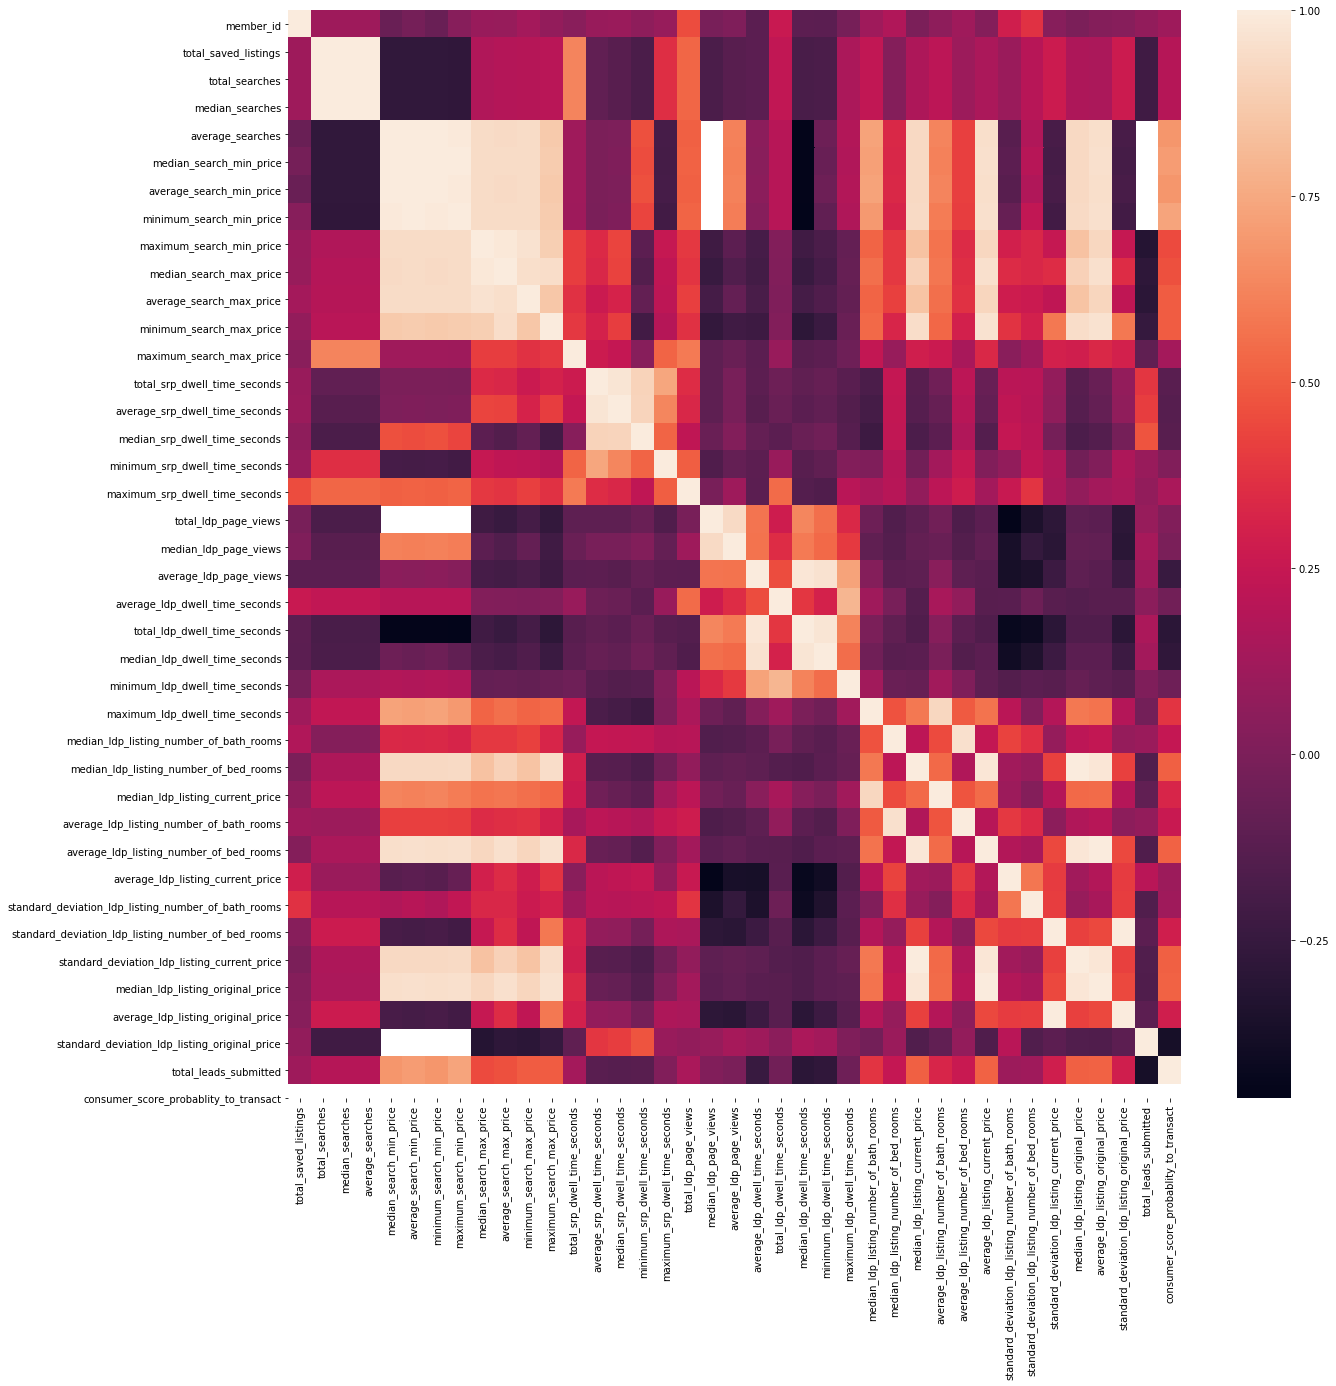

In [13]:
df_for_sale_001_corr = df_for_sale_001.corr()
pyplot.figure(figsize=(20, 20))
sns.heatmap(df_for_sale_001_corr, xticklabels=df_for_sale_001_corr.columns, yticklabels=df_for_sale_001.columns)

In [14]:
res = df_for_sale_001['total_leads_submitted'].corr(df_for_sale_001['consumer_score_probablity_to_transact'])
print(" correlation between lead_submition to consumer score : {}".format(str(res)))

 correlation between lead_submition to consumer score : -0.3706439924088167


In [15]:
df_for_sale_001.to_csv("filtered_intr_lead_trans_001.csv")